In [2]:
## https://stackoverflow.com/questions/44650888/resize-an-image-without-distortion-opencv

In [218]:
!cd models/research/object_detection

[Errno 2] No such file or directory: 'models/research/object_detection'
/home/scar3crow/Dropbox/WorkStation-Subrata/python/models/research/object_detection


In [219]:
import numpy as np
import pandas as pd
import cv2
import os
import tqdm
from scipy.io import loadmat

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from PIL import Image
import pytesseract

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K

from utils import *

from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.layers import *

from keras.applications import MobileNetV2
from keras.applications import InceptionResNetV2

from keras.models import Model
from keras.models import model_from_json


In [6]:
# Making a list of image path

inv_directory = '/home/scar3crow/Downloads/INVOICES/8-6-short'  ## 'invoices' is a zip file of jpg images in ...../Downloads 
                                                        
inv_image = ['/home/scar3crow/Downloads/INVOICES/8-6-short/{}'.format(i) for i in os.listdir(inv_directory)] # making the list
inv_image.sort() # Sorting the list

print('Number of images = ', len(inv_image))
inv_image[50]

Number of images =  64


'/home/scar3crow/Downloads/INVOICES/8-6-short/56a.jpg'

In [9]:
# Check sizes of exiting images :

# Create a Dataframe with image id and height(row) and width(column):

rows = []
columns = []
image_sl = []
df = pd.DataFrame()

for i in range(len(inv_image)):
    image = cv2.imread(inv_image[i]) ## Loading image
    height, width, _ = image.shape
    rows.append(height)
    columns.append(width)
    image_sl.append(inv_image[i])
    
row_values = pd.Series(rows)
col_values = pd.Series(columns)
image_num = pd.Series(image_sl)


df.insert(loc=0, column='image_serial', value=image_num)
df.insert(loc=1, column='rows', value=row_values)
df.insert(loc=2, column='columns', value=col_values)


print('max height = ', max(df['rows']))
print('max width = ', max(df['columns']))
df.tail(3)

max height =  326
max width =  554


,image_serial,rows,columns
61,/home/scar3crow/Downloads/INVOICES/8-6-short/7...,258,503
62,/home/scar3crow/Downloads/INVOICES/8-6-short/8...,169,510
63,/home/scar3crow/Downloads/INVOICES/8-6-short/9...,200,471


In [44]:
# Loading output of VGG Image Annotation tool and create a dataframe

r_1_data = pd.read_csv('/home/scar3crow/Downloads/invoice_data_1/short_via_data/1st_via_short.csv')
r_2_data = pd.read_csv('/home/scar3crow/Downloads/invoice_data_1/short_via_data/2nd_via_short.csv')
r_3_data = pd.read_csv('/home/scar3crow/Downloads/invoice_data_1/short_via_data/3rd_via_short.csv')

r_data = pd.concat([r_1_data, r_2_data, r_3_data], ignore_index=True, sort =False)

num_obj = r_data['region_count'][0] # number of objects in each photo
r_data.drop(r_data.columns[[1, 2, 3, 4]], axis=1, inplace=True) # reduce unnecessary columns
r_data.rename({'#filename': 'img_id'}, axis=1, inplace=True) # changing column name
num_images = r_data["img_id"].nunique() # Find out number of unique images

print('Number of classes = ', num_obj)
print('Number of unique images = ', num_images)
r_data.head()


r_data.tail(3)

Number of classes =  5
Number of unique images =  64


,img_id,region_shape_attributes,region_attributes
317,62a.jpg,"{""name"":""rect"",""x"":290,""y"":40,""width"":47,""heig...","{""text"":""invoice""}"
318,62a.jpg,"{""name"":""rect"",""x"":405,""y"":41,""width"":60,""heig...","{""text"":""inv_date""}"
319,62a.jpg,"{""name"":""rect"",""x"":290,""y"":103,""width"":71,""hei...","{""text"":""po""}"


In [45]:
# Making a dataframe for Image_id, x, y, width, height and class

x = []
y = []
width = []
height = []
obj_class = []
i_width = []
i_height = []


for i in range(len(r_data)):
    
    r_size = r_data.values[i, 1][1:(len(r_data.values[i, 1])-1)]
    r_size_par = r_size.split(",")
    
    x.append(int("".join(filter(str.isdigit, r_size_par[1]))))
    y.append(int("".join(filter(str.isdigit, r_size_par[2]))))
    width.append(int("".join(filter(str.isdigit, r_size_par[3]))))
    height.append(int("".join(filter(str.isdigit, r_size_par[4]))))
    
    r_attribs = r_data.values[i, 2][1:(len(r_data.values[i, 2])-1)]
    r_attribs_par = r_attribs.split(':')[1]
    obj_class.append(r_attribs_par[1:(len(r_attribs_par)-1)])
    
    foto_id = r_data['img_id'][i]
    img_path = '/home/scar3crow/Downloads/INVOICES/8-6-short/' + foto_id
    foto_index = df.index[df['image_serial'] == img_path]
    foto_width = df['columns'][foto_index].tolist()
    foto_height = df['rows'][foto_index].tolist()
    i_width.append(foto_width[0])
    i_height.append(foto_height[0])
    
x_values = pd.Series(x)
y_values = pd.Series(y)
width_values = pd.Series(width)
height_values = pd.Series(height)
class_values = pd.Series(obj_class)
i_width_values = pd.Series(i_width)
i_height_values = pd.Series(i_height)

r_data.insert(loc=1, column='x', value=x_values)
r_data.insert(loc=2, column='y', value=y_values)
r_data.insert(loc=3, column='box_width', value=width_values)
r_data.insert(loc=4, column='box_height', value=height_values)
r_data.insert(loc=5, column='obj_class', value=class_values)

r_data.insert(loc=8, column='image_width', value=i_width_values)
r_data.insert(loc=9, column='image_height', value=i_height_values)


r_data.drop(r_data.columns[[6, 7]], axis=1, inplace=True) # reduce unnecessary columns

r_data.head(10)

,img_id,x,y,box_width,box_height,obj_class,image_width,image_height
0,1a.jpg,43,28,347,60,vendor,504,279
1,1a.jpg,267,183,210,88,buyer,504,279
2,1a.jpg,16,105,138,16,invoice,504,279
3,1a.jpg,16,90,126,15,inv_date,504,279
4,1a.jpg,16,131,133,18,po,504,279
5,2a.jpg,7,37,199,60,vendot,502,172
6,2a.jpg,8,100,210,56,buyer,502,172
7,2a.jpg,279,35,71,27,invoice,502,172
8,2a.jpg,385,36,61,26,inv_date,502,172
9,2a.jpg,278,96,77,27,po,502,172


In [46]:
r_data.tail()

,img_id,x,y,box_width,box_height,obj_class,image_width,image_height
315,62a.jpg,23,42,164,54,vendor,540,212
316,62a.jpg,24,108,189,72,buyer,540,212
317,62a.jpg,290,40,47,24,invoice,540,212
318,62a.jpg,405,41,60,24,inv_date,540,212
319,62a.jpg,290,103,71,28,po,540,212


In [47]:
print('Number of unique images = ', r_data['img_id'].nunique())  # print total no, of unique images

print('Number of classes in diff. categories = ', r_data['obj_class'].value_counts()) 


Number of unique images =  64
Number of classes in diff. categories =  buyer       64
po          64
inv_date    64
invoice     63
vendor      62
vndor        1
invoie       1
vendot       1
Name: obj_class, dtype: int64


In [48]:
# Correcting above wrong spelling of object classes and rechecking

id_1 = r_data.index[r_data['obj_class'] == 'vndor'] # Finding the index
id_2 = r_data.index[r_data['obj_class'] == 'invoie'] # Finding the index
id_3 = r_data.index[r_data['obj_class'] == 'vendot'] # Finding the index

r_data.at[id_1, 'obj_class'] = 'vendor' # writing the correct spelling 
r_data.at[id_2, 'obj_class'] = 'invoice' # # writing the correct spelling
r_data.at[id_3, 'obj_class'] = 'vendor' # # writing the correct spelling

print('Number of unique images = ', r_data['img_id'].nunique())  # print total no, of unique images
print('Number of unique classes = ', r_data['obj_class'].nunique())
print('Number of classes in diff. categories = ', r_data['obj_class'].value_counts()) 


Number of unique images =  64
Number of unique classes =  5
Number of classes in diff. categories =  vendor      64
buyer       64
po          64
inv_date    64
invoice     64
Name: obj_class, dtype: int64


(212, 540, 3)
(224, 224, 3)


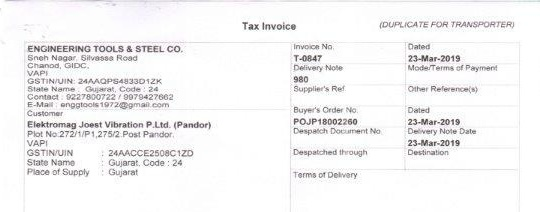

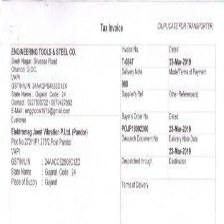

In [70]:
image_path = '/home/scar3crow/Downloads/INVOICES/8-6-short/' + '62a.jpg'
    
x = cv2.imread(image_path)
y = cv2.resize(x,(224,224))
print(x.shape)
print(y.shape)

x_pil = Image.fromarray(x)
y_pil = Image.fromarray(y)

display(x_pil)
display(y_pil)

In [53]:
def resize_and_letter_box(image, rows, cols):
    """
    Letter box (black bars) a color image (think pan & scan movie shown 
    on widescreen) if not same aspect ratio as specified rows and cols. 
    :param image: numpy.ndarray((image_rows, image_cols, channels), dtype=numpy.uint8)
    :param rows: int rows of letter boxed image returned  
    :param cols: int cols of letter boxed image returned
    :return: numpy.ndarray((rows, cols, channels), dtype=numpy.uint8)
    """
    image_rows, image_cols = image.shape[:2]
    row_ratio = rows / float(image_rows)
    col_ratio = cols / float(image_cols)
    ratio = min(row_ratio, col_ratio)
    image_resized = cv2.resize(image, dsize=(0, 0), fx=ratio, fy=ratio)
    letter_box = np.zeros((int(rows), int(cols), 3))
    row_start = int((letter_box.shape[0] - image_resized.shape[0]) / 2)
    col_start = int((letter_box.shape[1] - image_resized.shape[1]) / 2)
    letter_box[row_start:row_start + image_resized.shape[0], col_start:col_start + image_resized.shape[1]] = image_resized
    return letter_box


In [58]:
categories = r_data['obj_class'].unique() # make a list of unique images

values = np.array(categories)
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y_encoded = onehot_encoder.fit_transform(integer_encoded)

print(categories)                               
print(y_encoded)


['vendor' 'buyer' 'invoice' 'inv_date' 'po']
[[0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]


In [172]:
# Preparing Input(X) and Target(Y) file for training :

# Variable Definition

channels = 3
anchors = 1
classes = 5 # vendor, buyer, invoice, inv_date, po, item_detail, totals
info = 5 + classes    # pc, x, y, h, w, and class probabilities

grid_y_axis = 14  # each image is to be segmented to 16 x 16 grid
grid_x_axis = 14  # # each image is to be segmented to 16 x 16 grid

img_w = 224 # target sizes as per MobileNetV2
img_h = 224 #target sizes as per MobileNetV2

# Start :

X_final = [] # X_final list to convert to np array later
Y_final = [] # Y_final list to convert to np array later

image_list = r_data['img_id'].unique() # make a list of unique images

for i in image_list:
    
    image_path = '/home/scar3crow/Downloads/INVOICES/8-6-short/' + i
    
    x = cv2.imread(image_path)
    x_ratio = img_w / x.shape[1]
    y_ratio = img_h / x.shape[0]
    img = cv2.resize(x,(img_w, img_h))
    
    X_final.append(img)
    
    Y = np.zeros((grid_y_axis,grid_x_axis,1,info))
    
    r_data_slice = r_data.loc[r_data['img_id'].isin([i])].reset_index(drop=True) # slicing as per current image id
    
    for j in range(len(r_data_slice)):
        
        xmin = r_data_slice['x'][j] * x_ratio
        ymin = r_data_slice['y'][j] * y_ratio
        
        xmax = (r_data_slice['x'][j] + r_data_slice['box_width'][j]) * x_ratio
        ymax = (r_data_slice['y'][j] + r_data_slice['box_height'][j]) * y_ratio
        
        obj_class = r_data_slice['obj_class'][j]
        
        w = (xmax - xmin)/img_w
        h = (ymax - ymin)/img_h

        x = (xmin + (xmax-xmin)/2)/img_w
        y = (ymin + (ymax-ymin)/2)/img_h
        
        x = x * grid_y_axis
        y = y * grid_x_axis
        
        Y[int(y),int(x),0,0] = 1
        Y[int(y),int(x),0,1] = x - int(x)
        Y[int(y),int(x),0,2] = y - int(y)
        Y[int(y),int(x),0,3] = w
        Y[int(y),int(x),0,4] = h
        
        balance_Y = y_encoded[categories.tolist().index(obj_class), :]
        
        Y[int(y),int(x),0,5] = balance_Y[0]
        Y[int(y),int(x),0,6] = balance_Y[1]
        Y[int(y),int(x),0,7] = balance_Y[2]
        Y[int(y),int(x),0,8] = balance_Y[3]
        Y[int(y),int(x),0,9] = balance_Y[4]
        
        print(i, int(y), int(x))
        print(Y[int(y),int(x),0])
        
    
        
    Y_final.append(Y)
    print('==================================================')
print('++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print(Y_final)
X = np.array(X_final) 
#X_final = []
Y = np.array(Y_final)
#Y_final = []

X = (X - 127.5)/127.5  # X normalising since pixels vary from 0 to 255
    
np.save('/home/scar3crow/Downloads/Data1/X_short.npy',X)
np.save('/home/scar3crow/Downloads/Data1/Y_short.npy',Y)


1a.jpg 2 6
[1.         0.01388889 0.91039427 0.68849206 0.21505376 0.
 0.         0.         0.         1.        ]
1a.jpg 11 10
[1.         0.33333333 0.390681   0.41666667 0.31541219 1.
 0.         0.         0.         0.        ]
1a.jpg 5 2
[1.         0.36111111 0.6702509  0.27380952 0.05734767 0.
 0.         1.         0.         0.        ]
1a.jpg 4 2
[1.         0.19444444 0.89247312 0.25       0.05376344 0.
 1.         0.         0.         0.        ]
1a.jpg 7 2
[1.         0.29166667 0.02508961 0.26388889 0.06451613 0.
 0.         0.         1.         0.        ]
2a.jpg 5 2
[1.         0.97011952 0.45348837 0.39641434 0.34883721 0.
 0.         0.         0.         1.        ]
2a.jpg 10 3
[1.         0.15139442 0.41860465 0.41832669 0.3255814  1.
 0.         0.         0.         0.        ]
2a.jpg 3 8
[1.         0.77091633 0.94767442 0.14143426 0.15697674 0.
 0.         1.         0.         0.        ]
2a.jpg 3 11
[1.         0.5876494  0.98837209 0.12151394 0.15116279 0

28a.jpg 3 2
[1.         0.88977956 0.37272727 0.34468938 0.24545455 0.
 0.         0.         0.         1.        ]
28a.jpg 6 3
[1.         0.22645291 1.         0.39278557 0.27272727 1.
 0.         0.         0.         0.        ]
28a.jpg 2 8
[1.         0.34669339 0.54545455 0.13827655 0.10909091 0.
 0.         1.         0.         0.        ]
28a.jpg 2 11
[1.         0.04008016 0.60909091 0.11823647 0.10909091 0.
 1.         0.         0.         0.        ]
28a.jpg 6 8
[1.         0.41683367 0.07727273 0.14428858 0.10454545 0.
 0.         0.         1.         0.        ]
29a.jpg 7 7
[1.         0.08844765 0.27898551 0.69855596 0.16304348 0.
 0.         0.         0.         1.        ]
29a.jpg 10 5
[1.         0.05415162 0.22101449 0.45487365 0.17028986 1.
 0.         0.         0.         0.        ]
29a.jpg 4 2
[1.         0.48916968 0.8442029  0.25090253 0.09057971 0.
 0.         1.         0.         0.        ]
29a.jpg 4 11
[1.         0.37184116 0.94565217 0.15884477 0.08

55a.jpg 3 3
[1.         0.0524109  0.92270531 0.30188679 0.2705314  0.
 0.         0.         0.         1.        ]
55a.jpg 8 3
[1.         0.65408805 0.52173913 0.38784067 0.36714976 1.
 0.         0.         0.         0.        ]
55a.jpg 3 8
[1.         0.61425577 0.07729469 0.09853249 0.11111111 0.
 0.         1.         0.         0.        ]
55a.jpg 3 11
[1.         0.51991614 0.24637681 0.1278826  0.10628019 0.
 1.         0.         0.         0.        ]
55a.jpg 6 9
[1.         0.24528302 0.8647343  0.18867925 0.11111111 0.
 0.         0.         1.         0.        ]
56a.jpg 4 2
[1.         0.69333333 0.08910891 0.29714286 0.27722772 0.
 0.         0.         0.         1.        ]
56a.jpg 8 3
[1.         0.24       0.94059406 0.36761905 0.34653465 1.
 0.         0.         0.         0.        ]
56a.jpg 2 8
[1.         0.49333333 0.87623762 0.08571429 0.11386139 0.
 0.         1.         0.         0.        ]
56a.jpg 2 11
[1.         0.44       0.80693069 0.11428571 0.123

In [173]:
Y.shape

(64, 14, 14, 1, 10)

In [174]:
X_train , X_val , Y_train , Y_val  = train_test_split(X,Y,train_size = 0.80, shuffle = True)
Y[0, 0, 0]

/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [175]:
def my_model(input_shape):
    
    
    inp = Input(input_shape)
   
    model = MobileNetV2( input_tensor= inp , include_top=False, weights='imagenet')
    last_layer = model.output
    
#    last_3 = Flatten()(last_layer)
#    last_2 = Dense(640, activation = 'relu')(last_3)
#    last_1 = Dense(320, activation = 'relu')(last_2)
#    last_0 = Dense(7, activation = 'softmax')(last_1
    last_3 = UpSampling2D(2)(last_layer)

    last_2 = Conv2D(640,(3,3) , activation='relu' , padding='same')(last_3)
    
    last_1 = Conv2D(320,(1,1) , activation='relu' , padding='valid')(last_2)
    
    last_0 = Conv2D(10,(1,1) , activation='relu' , padding='valid')(last_1)
    
    final = Reshape((grid_y_axis,grid_x_axis,anchors,info))(last_0)
        
    model = Model(inp,final)
    
    return model


In [176]:
input_size = (img_h,img_w,3)

my_invoice_model_1 = my_model(input_size)

print(my_invoice_model_1.summary())


/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

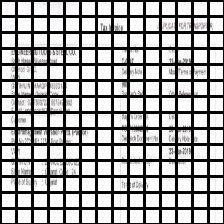

In [73]:

image_copy = y.copy()

m = int(224/14)
n = int(224/7)

x_range = [0, m*1, m*2, m*3, m*4, m*5, m*6, m*7, m*8, m*9, m*10, m*11, m*12, m*13, m*14, m*15]
y_range = [0, m*1, m*2, m*3, m*4, m*5, m*6, m*7, m*8, m*9, m*10, m*11, m*12, m*13, m*14, m*15]


for i in x_range:
    for j in y_range:
        cv2.rectangle(image_copy, (i, j), (i+32, j+32), 0, 2)
    
img_pil = Image.fromarray(image_copy)
display(img_pil)


In [177]:
#define loss function

def yolo_loss_func(y_true,y_pred):
    
    # y_true : 7,7,1, 10
    # y_pred : 7,7,1, 10
    
    l_coords = 5.0
    l_noob = 0.5
    
    coords = y_true[:,:,:,:,0] * l_coords  # If the grid has a object - weitage increased by l_coords(5 times)
    noobs = (-1*(y_true[:,:,:,:,0] - 1)*l_noob) # If the grid does not have an object - penalised
    p_pred = y_pred[:,:,:,:,0]
    p_true = y_true[:,:,:,:,0]
    x_true = y_true[:,:,:,:,1]
    x_pred = y_pred[:,:,:,:,1]
    yy_true = y_true[:,:,:,:,2]
    yy_pred = y_pred[:,:,:,:,2]
    w_true = y_true[:,:,:,:,3]
    w_pred = y_pred[:,:,:,:,3]
    h_true = y_true[:,:,:,:,4]
    h_pred = y_pred[:,:,:,:,4]
    
    class_true = y_true[:,:,:,:,5:9]
    class_pred = y_pred[:,:,:,:,5:9]
    
    
    p_loss_absent = K.sum(K.square(p_pred - p_true)*noobs)
    p_loss_present = K.sum(K.square(p_pred - p_true)) * (coords / l_coords) # (coords/l_coords) added by me to 
                                                                            # exactly follow yolo loss formula
    x_loss = K.sum(K.square(x_pred - x_true)*coords)
    yy_loss = K.sum(K.square(yy_pred - yy_true)*coords)
    xy_loss = x_loss + yy_loss
    
    w_loss = K.sum(K.square(K.sqrt(w_pred) - K.sqrt(w_true))*coords)
    h_loss = K.sum(K.square(K.sqrt(h_pred) - K.sqrt(h_true))*coords)
    wh_loss = w_loss + h_loss
    
    class_loss = K.sum(K.sum(K.square(class_pred - class_true)) * (coords / l_coords)) # added by me
    
    
    loss = p_loss_absent + p_loss_present + xy_loss + wh_loss + class_loss
    
    return loss

In [164]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

my_invoice_model_1.compile(loss=yolo_loss_func , optimizer=opt , metrics = ['accuracy'])

In [165]:
Y_train.shape

(51, 14, 14, 1, 10)

In [166]:
my_invoice_model_1.fit(X_train, Y_train, epochs= 10, batch_size = 4, validation_data=(X_val,Y_val))

Train on 51 samples, validate on 13 samples
Epoch 1/10
51/51 [==============================] - 28s 558ms/step - loss: nan - accuracy: 0.9268 - val_loss: nan - val_accuracy: 1.0000
Epoch 2/10
51/51 [==============================] - 18s 360ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 3/10
51/51 [==============================] - 18s 362ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 4/10
51/51 [==============================] - 19s 363ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 5/10
51/51 [==============================] - 19s 363ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 6/10
51/51 [==============================] - 18s 361ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 7/10
51/51 [==============================] - 18s 361ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.00

In [95]:
my_invoice_model.compile(optimizer= opt,loss='categorical_crossentropy',metrics=['accuracy'])
my_invoice_model.fit(X_train, Y_train, epochs= 10, batch_size = 4, validation_data=(X_val,Y_val))

Train on 51 samples, validate on 13 samples
Epoch 1/10
51/51 [==============================] - 24s 479ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 2/10
51/51 [==============================] - 16s 310ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 3/10
51/51 [==============================] - 16s 316ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 4/10
51/51 [==============================] - 16s 314ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 5/10
51/51 [==============================] - 16s 321ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 6/10
51/51 [==============================] - 19s 363ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 7/10
51/51 [==============================] - 18s 346ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.00

In [141]:
Y_train[6]

array([[[[0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ]]],

In [133]:
Y_train[38].shape

(7, 7, 1, 10)

In [124]:
image_path = inv_image[10]
    
x = cv2.imread(image_path)

img_1 = (cv2.resize(x,(img_w, img_h))-127.5)/127.5

img_1 = x = np.expand_dims(img_1, axis=0)

preds = my_invoice_model.predict(img_1)
print(image_path)
preds

/home/scar3crow/Downloads/INVOICES/8-6-short/1a.jpg


array([[[[[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],

         [[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],

         [[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],

         [[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],

         [[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],

         [[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],

         [[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]]],


        [[[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],

         [[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],

         [[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],

         [[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],

         [[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],

         [[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],

         [[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]]],


        [[[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],

         [[nan, nan, nan, nan, nan, 

In [178]:
# Preparing Input(X) and Target(Y) file for training :

# Variable Definition

channels = 3
anchors = 1
classes = 5 # vendor, buyer, invoice, inv_date, po, item_detail, totals
info = 5 + classes    # pc, x, y, h, w, and class probabilities

grid_y_axis = 14  # each image is to be segmented to 16 x 16 grid
grid_x_axis = 14  # # each image is to be segmented to 16 x 16 grid

img_w = 224 # target sizes as per MobileNetV2
img_h = 224 #target sizes as per MobileNetV2

# Start :

X_final = [] # X_final list to convert to np array later
Y_final = [] # Y_final list to convert to np array later

image_list = r_data['img_id'].unique() # make a list of unique images

for i in image_list:
    
    image_path = '/home/scar3crow/Downloads/INVOICES/8-6-short/' + i
    
    x = cv2.imread(image_path)
    x_ratio = img_w / x.shape[1]
    y_ratio = img_h / x.shape[0]
    img = cv2.resize(x,(img_w, img_h))
    
    X_final.append(img)
    
    Y = np.zeros((grid_y_axis,grid_x_axis,info))
    
    r_data_slice = r_data.loc[r_data['img_id'].isin([i])].reset_index(drop=True) # slicing as per current image id
    
    for j in range(len(r_data_slice)):
        
        xmin = r_data_slice['x'][j] * x_ratio
        ymin = r_data_slice['y'][j] * y_ratio
        
        xmax = (r_data_slice['x'][j] + r_data_slice['box_width'][j]) * x_ratio
        ymax = (r_data_slice['y'][j] + r_data_slice['box_height'][j]) * y_ratio
        
        obj_class = r_data_slice['obj_class'][j]
        
        w = (xmax - xmin)/img_w
        h = (ymax - ymin)/img_h

        x = (xmin + (xmax-xmin)/2)/img_w
        y = (ymin + (ymax-ymin)/2)/img_h
        
        x = x * grid_y_axis
        y = y * grid_x_axis
        
        Y[int(y),int(x),0] = 1
        Y[int(y),int(x),1] = x - int(x)
        Y[int(y),int(x),2] = y - int(y)
        Y[int(y),int(x),3] = w
        Y[int(y),int(x),4] = h
        
        balance_Y = y_encoded[categories.tolist().index(obj_class), :]
        
        Y[int(y),int(x),5] = balance_Y[0]
        Y[int(y),int(x),6] = balance_Y[1]
        Y[int(y),int(x),7] = balance_Y[2]
        Y[int(y),int(x),8] = balance_Y[3]
        Y[int(y),int(x),9] = balance_Y[4]
        
        print(i, int(y), int(x))
        print(Y[int(y),int(x)])
        
    
        
    Y_final.append(Y)
    print('==================================================')
print('++++++++++++++++++++++++++++++++++++++++++++++++++++++')
print(Y_final)
X = np.array(X_final) 
#X_final = []
Y = np.array(Y_final)
#Y_final = []

X = (X - 127.5)/127.5  # X normalising since pixels vary from 0 to 255
    
# np.save('/home/scar3crow/Downloads/Data1/X_short.npy',X)
# np.save('/home/scar3crow/Downloads/Data1/Y_short.npy',Y)


1a.jpg 2 6
[1.         0.01388889 0.91039427 0.68849206 0.21505376 0.
 0.         0.         0.         1.        ]
1a.jpg 11 10
[1.         0.33333333 0.390681   0.41666667 0.31541219 1.
 0.         0.         0.         0.        ]
1a.jpg 5 2
[1.         0.36111111 0.6702509  0.27380952 0.05734767 0.
 0.         1.         0.         0.        ]
1a.jpg 4 2
[1.         0.19444444 0.89247312 0.25       0.05376344 0.
 1.         0.         0.         0.        ]
1a.jpg 7 2
[1.         0.29166667 0.02508961 0.26388889 0.06451613 0.
 0.         0.         1.         0.        ]
2a.jpg 5 2
[1.         0.97011952 0.45348837 0.39641434 0.34883721 0.
 0.         0.         0.         1.        ]
2a.jpg 10 3
[1.         0.15139442 0.41860465 0.41832669 0.3255814  1.
 0.         0.         0.         0.        ]
2a.jpg 3 8
[1.         0.77091633 0.94767442 0.14143426 0.15697674 0.
 0.         1.         0.         0.        ]
2a.jpg 3 11
[1.         0.5876494  0.98837209 0.12151394 0.15116279 0

32a.jpg 8 2
[1.         0.55871212 0.32492114 0.26325758 0.36277603 0.
 0.         0.         0.         1.        ]
32a.jpg 7 7
[1.         0.45075758 0.88328076 0.31060606 0.28706625 1.
 0.         0.         0.         0.        ]
32a.jpg 11 2
[1.         0.81060606 0.94637224 0.29545455 0.04100946 0.
 0.         1.         0.         0.        ]
32a.jpg 11 9
[1.         0.61174242 0.99053628 0.27462121 0.04731861 0.
 1.         0.         0.         0.        ]
32a.jpg 12 2
[1.         0.89015152 0.45425868 0.3030303  0.04416404 0.
 0.         0.         1.         0.        ]
33a.jpg 8 2
[1.         0.71052632 0.67391304 0.27067669 0.35093168 0.
 0.         0.         0.         1.        ]
33a.jpg 8 7
[1.         0.48684211 0.10869565 0.30639098 0.28881988 1.
 0.         0.         0.         0.        ]
33a.jpg 12 2
[1.         0.93421053 0.15217391 0.28759398 0.04658385 0.
 0.         1.         0.         0.        ]
33a.jpg 12 9
[1.         0.67105263 0.13043478 0.27255639 0.

[1.         0.70925926 0.86861314 0.36111111 0.17518248 0.
 0.         0.         0.         1.        ]
60a.jpg 10 2
[1.         0.78703704 0.72992701 0.37222222 0.22627737 1.
 0.         0.         0.         0.        ]
60a.jpg 7 8
[1.         0.69814815 0.07664234 0.09444444 0.08394161 0.
 0.         1.         0.         0.        ]
60a.jpg 7 11
[1.         0.42037037 0.05109489 0.11666667 0.09489051 0.
 1.         0.         0.         0.        ]
60a.jpg 10 9
[1.         0.25555556 0.01459854 0.17037037 0.09489051 0.
 0.         0.         1.         0.        ]
61a.jpg 4 2
[1.         0.56578947 0.63425926 0.30639098 0.25462963 0.
 0.         0.         0.         1.        ]
61a.jpg 9 2
[1.         0.93421053 0.49537037 0.36278195 0.3287037  1.
 0.         0.         0.         0.        ]
61a.jpg 3 8
[1.         0.03947368 0.75925926 0.08834586 0.11111111 0.
 0.         1.         0.         0.        ]
61a.jpg 3 11
[1.         0.21052632 0.75925926 0.11278195 0.12037037 0.
 

In [179]:
Y.shape

(64, 14, 14, 10)

In [180]:
X_train , X_val , Y_train , Y_val  = train_test_split(X,Y,train_size = 0.80, shuffle = True)

/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [181]:
def my_model(input_shape):
    
    
    inp = Input(input_shape)
   
    model = MobileNetV2( input_tensor= inp , include_top=False, weights='imagenet')
    last_layer = model.output
    
#    last_3 = Flatten()(last_layer)
#    last_2 = Dense(640, activation = 'relu')(last_3)
#    last_1 = Dense(320, activation = 'relu')(last_2)
#    last_0 = Dense(7, activation = 'softmax')(last_1
    last_3 = UpSampling2D(2)(last_layer)

    last_2 = Conv2D(640,(3,3) , activation='relu' , padding='same')(last_3)
    
    last_1 = Conv2D(320,(1,1) , activation='relu' , padding='valid')(last_2)
    
    last_0 = Conv2D(10,(1,1) , activation='relu' , padding='valid')(last_1)
    
#    final = Reshape((grid_y_axis,grid_x_axis,anchors,info))(last_0)
        
#    model = Model(inp,final)
    
    model = Model(inp,last_0)
    
    return model


In [182]:
input_size = (img_h,img_w,3)

my_invoice_model_2 = my_model(input_size)

print(my_invoice_model_2.summary())


/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [183]:
my_invoice_model_2.compile(optimizer= opt,loss='categorical_crossentropy',metrics=['accuracy'])
my_invoice_model_2.fit(X_train, Y_train, epochs= 10, batch_size = 4, validation_data=(X_val,Y_val))

Train on 51 samples, validate on 13 samples
Epoch 1/10
51/51 [==============================] - 34s 675ms/step - loss: 0.3793 - accuracy: 0.2742 - val_loss: 0.1822 - val_accuracy: 0.9737
Epoch 2/10
51/51 [==============================] - 18s 361ms/step - loss: 0.1685 - accuracy: 0.9631 - val_loss: 0.1797 - val_accuracy: 0.9906
Epoch 3/10
51/51 [==============================] - 19s 365ms/step - loss: 0.1601 - accuracy: 0.9900 - val_loss: 0.1781 - val_accuracy: 0.9902
Epoch 4/10
51/51 [==============================] - 20s 383ms/step - loss: 0.1542 - accuracy: 0.9833 - val_loss: 0.1906 - val_accuracy: 0.9863
Epoch 5/10
51/51 [==============================] - 20s 387ms/step - loss: 0.1495 - accuracy: 0.9649 - val_loss: 0.2138 - val_accuracy: 0.9768
Epoch 6/10
51/51 [==============================] - 19s 382ms/step - loss: 0.1480 - accuracy: 0.9467 - val_loss: 0.2400 - val_accuracy: 0.9694
Epoch 7/10
51/51 [==============================] - 18s 360ms/step - loss: 0.1454 - accuracy: 0.91

In [185]:
image_path = inv_image[10]
    
x = cv2.imread(image_path)

img_1 = (cv2.resize(x,(img_w, img_h))-127.5)/127.5

img_1 = x = np.expand_dims(img_1, axis=0)

preds = my_invoice_model_2.predict(img_1)
print(image_path)
preds

/home/scar3crow/Downloads/INVOICES/8-6-short/1a.jpg


array([[[[1.1409308 , 0.5386436 , 0.15686968, ..., 0.44384974,
          0.08658402, 0.5379877 ],
         [1.8219107 , 0.76378226, 0.8159566 , ..., 0.5542074 ,
          0.4243224 , 0.75853336],
         [2.2224305 , 1.1502597 , 0.9248821 , ..., 0.7112378 ,
          0.3950408 , 1.0952538 ],
         ...,
         [2.4383945 , 0.5946529 , 1.1297392 , ..., 0.38103515,
          0.8922577 , 0.08273434],
         [1.9559432 , 0.26300508, 0.7834212 , ..., 0.01822135,
          0.603932  , 0.152039  ],
         [0.76962227, 0.        , 0.7907762 , ..., 0.15495932,
          0.3101351 , 0.04494818]],

        [[2.6647248 , 1.1037488 , 0.88584507, ..., 0.885528  ,
          0.06538343, 1.6922023 ],
         [4.5251355 , 1.84586   , 1.5291674 , ..., 0.76220447,
          0.38163018, 2.019563  ],
         [5.319225  , 2.596699  , 1.5453496 , ..., 1.0757617 ,
          0.32212126, 2.722549  ],
         ...,
         [5.5820336 , 1.5208669 , 1.8343375 , ..., 1.0990622 ,
          1.3080914 , 1.1

In [203]:
# output shape = (1, a, b, 10)

def decode_to_boxes(output , ht , wd):   # output = model.predict, ht = img_h = 512, wd = img_w = 512
    #output : (x,x,1,12)
    #x,y,h,w

    img_ht = ht
    img_wd = wd
    threshold = 0.5
    grid_y_axis, grid_x_axis = output.shape[:2]
    final_boxes = []
    scores_top = []
    scores_class = []

    for i in range(grid_y_axis):
        for j in range(grid_x_axis):
            if output[0,i,j][0] > threshold:

                temp_1 = output[0,i, j, 1:5]
                temp_2 = output[0,i, j, 5:12]
                
                x_unit = ((j + (temp_1[0])) / grid_y_axis) * img_wd
                y_unit = ((i + (temp_1[1])) / grid_x_axis) * img_ht
                
                w_unit = temp_1[2] * img_wd
                h_unit = temp_1[3] * img_ht
                
                xmax = x_unit + w_unit * 0.5
                xmin = x_unit - w_unit * 0.5
                
                ymax = y_unit + h_unit * 0.5
                ymin = y_unit - h_unit * 0.5
                
                xmax_original = xmax / x_ratio
                xmin_original = xmin / x_ratio
                
                ymax_original = ymax / y_ratio
                ymin_original = ymin / y_ratio
                
                class_index = np.argmax(temp_2)
                obj_class = sorted(categories.tolist())[class_index]
                
                
                final_boxes.append([xmin_original, ymin_original, xmax_original, ymax_original], obj_class)
                scores_top.append(output[i,j,0], obj_class)
                scores_class.append(output[i, j, (5+class_index)], obj_class)
    
    return final_boxes,scores_top, scores_class


In [204]:
p, q, r = decode_to_boxes(preds, 224, 224)

IndexError: list index out of range

In [201]:
preds[0,0,0]

array([1.1409308 , 0.5386436 , 0.15686968, 0.35020316, 0.28652894,
       0.        , 0.31708792, 0.44384974, 0.08658402, 0.5379877 ],
      dtype=float32)

In [198]:
preds.shape

(1, 14, 14, 10)

In [202]:
preds[0,0,0,0]

1.1409308

In [206]:
def my_model(input_shape):
    
    
    inp = Input(input_shape)
   
    model = MobileNetV2( input_tensor= inp , include_top=False, weights='imagenet')
    last_layer = model.output
    
    last_3 = Flatten()(last_layer)
#    last_2 = Dense(640, activation = 'relu')(last_3)
#    last_1 = Dense(320, activation = 'relu')(last_2)
#    last_0 = Dense(7, activation = 'relu')(last_1
    last_3 = UpSampling2D(2)(last_layer)

    last_2 = Conv2D(640,(3,3) , activation='relu' , padding='same')(last_3)
    
    last_1 = Conv2D(320,(1,1) , activation='relu' , padding='valid')(last_2)
    
    last_0 = Conv2D(10,(1,1) , activation='softmax' , padding='valid')(last_1)
    
#    final = Reshape((grid_y_axis,grid_x_axis,anchors,info))(last_0)
        
#    model = Model(inp,final)
    
    model = Model(inp,last_0)
    
    return model


In [207]:
input_size = (img_h,img_w,3)

my_invoice_model_3 = my_model(input_size)

print(my_invoice_model_3.summary())


/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_12[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [208]:
my_invoice_model_3.compile(optimizer= opt,loss='categorical_crossentropy',metrics=['accuracy'])
my_invoice_model_3.fit(X_train, Y_train, epochs= 10, batch_size = 4, validation_data=(X_val,Y_val))

Train on 51 samples, validate on 13 samples
Epoch 1/10
51/51 [==============================] - 35s 687ms/step - loss: 0.2013 - accuracy: 0.5216 - val_loss: 0.1916 - val_accuracy: 0.4364
Epoch 2/10
51/51 [==============================] - 20s 384ms/step - loss: 0.1683 - accuracy: 0.6137 - val_loss: 0.1959 - val_accuracy: 0.7045
Epoch 3/10
51/51 [==============================] - 19s 378ms/step - loss: 0.1558 - accuracy: 0.7735 - val_loss: 0.2024 - val_accuracy: 0.7045
Epoch 4/10
51/51 [==============================] - 19s 374ms/step - loss: 0.1497 - accuracy: 0.7792 - val_loss: 0.2065 - val_accuracy: 0.8462
Epoch 5/10
51/51 [==============================] - 20s 399ms/step - loss: 0.1451 - accuracy: 0.7439 - val_loss: 0.2153 - val_accuracy: 0.7641
Epoch 6/10
51/51 [==============================] - 20s 386ms/step - loss: 0.1438 - accuracy: 0.7953 - val_loss: 0.2245 - val_accuracy: 0.7845
Epoch 7/10
51/51 [==============================] - 19s 370ms/step - loss: 0.1422 - accuracy: 0.77

In [210]:
image_path = inv_image[10]
    
x = cv2.imread(image_path)

img_1 = (cv2.resize(x,(img_w, img_h))-127.5)/127.5

img_1 = x = np.expand_dims(img_1, axis=0)

preds = my_invoice_model_3.predict(img_1)
print(image_path)
preds

/home/scar3crow/Downloads/INVOICES/8-6-short/1a.jpg


array([[[[4.88731772e-01, 1.71098351e-01, 1.24853224e-01, ...,
          6.12486852e-03, 1.09055741e-02, 2.64078360e-02],
         [5.46638310e-01, 2.19026089e-01, 1.25114456e-01, ...,
          4.70119156e-03, 3.78890559e-02, 2.99246842e-03],
         [4.44129139e-01, 2.25895137e-01, 1.98235735e-01, ...,
          5.06540621e-03, 3.03749163e-02, 3.10769654e-03],
         ...,
         [3.51819605e-01, 1.77795395e-01, 2.43053302e-01, ...,
          6.00158796e-03, 9.40190107e-02, 1.36149873e-03],
         [3.93280298e-01, 1.82659671e-01, 1.74434826e-01, ...,
          7.49500236e-03, 1.13273308e-01, 1.34038739e-03],
         [3.05622637e-01, 1.69257894e-01, 1.43327326e-01, ...,
          2.19030529e-02, 1.64315015e-01, 2.34657945e-03]],

        [[5.60570896e-01, 1.95466548e-01, 1.22058518e-01, ...,
          1.48285262e-03, 8.00001621e-03, 3.12142191e-03],
         [4.91861641e-01, 2.57777661e-01, 1.45139158e-01, ...,
          8.57968698e-04, 6.72645494e-02, 5.03495976e-05],
        

In [211]:
preds[0,0,0]

array([0.48873177, 0.17109835, 0.12485322, 0.07571287, 0.08277907,
       0.00705197, 0.00633443, 0.00612487, 0.01090557, 0.02640784],
      dtype=float32)

In [212]:
my_invoice_model_3.fit(X_train, Y_train, epochs= 10, batch_size = 4, validation_data=(X_val,Y_val))

Train on 51 samples, validate on 13 samples
Epoch 1/10
51/51 [==============================] - 19s 380ms/step - loss: 0.1394 - accuracy: 0.7675 - val_loss: 0.2244 - val_accuracy: 0.9313
Epoch 2/10
51/51 [==============================] - 19s 364ms/step - loss: 0.1383 - accuracy: 0.7889 - val_loss: 0.2240 - val_accuracy: 0.8862
Epoch 3/10
51/51 [==============================] - 19s 374ms/step - loss: 0.1384 - accuracy: 0.7844 - val_loss: 0.2169 - val_accuracy: 0.7991
Epoch 4/10
51/51 [==============================] - 19s 366ms/step - loss: 0.1390 - accuracy: 0.7633 - val_loss: 0.2143 - val_accuracy: 0.8332
Epoch 5/10
51/51 [==============================] - 21s 413ms/step - loss: 0.1386 - accuracy: 0.7954 - val_loss: 0.2166 - val_accuracy: 0.9003
Epoch 6/10
51/51 [==============================] - 19s 382ms/step - loss: 0.1378 - accuracy: 0.7952 - val_loss: 0.2147 - val_accuracy: 0.8909
Epoch 7/10
51/51 [==============================] - 20s 396ms/step - loss: 0.1378 - accuracy: 0.79

In [213]:
def my_model(input_shape):
    
    
    inp = Input(input_shape)
   
    model = MobileNetV2( input_tensor= inp , include_top=False, weights='imagenet')
    last_layer = model.output
    
    last_3 = Flatten()(last_layer)
#    last_2 = Dense(640, activation = 'relu')(last_3)
#    last_1 = Dense(320, activation = 'relu')(last_2)
#    last_0 = Dense(7, activation = 'relu')(last_1
    last_3 = UpSampling2D(2)(last_layer)

    last_2 = Conv2D(640,(3,3) , activation='relu' , padding='same')(last_3)
    
    last_1 = Conv2D(320,(1,1) , activation='softmax' , padding='valid')(last_2)
    
    last_0 = Conv2D(10,(1,1) , activation='softmax' , padding='valid')(last_1)
    
#    final = Reshape((grid_y_axis,grid_x_axis,anchors,info))(last_0)
        
#    model = Model(inp,final)
    
    model = Model(inp,last_0)
    
    return model


In [214]:
input_size = (img_h,img_w,3)

my_invoice_model_4 = my_model(input_size)

print(my_invoice_model_4.summary())


/home/scar3crow/Dropbox/WorkStation-Subrata/python/venv1/lib/python3.5/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_13[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [215]:
my_invoice_model_4.compile(optimizer= opt,loss='categorical_crossentropy',metrics=['accuracy'])
my_invoice_model_4.fit(X_train, Y_train, epochs= 10, batch_size = 4, validation_data=(X_val,Y_val))

Train on 51 samples, validate on 13 samples
Epoch 1/10
51/51 [==============================] - 46s 908ms/step - loss: 0.1962 - accuracy: 0.2223 - val_loss: 0.1959 - val_accuracy: 0.1589
Epoch 2/10
51/51 [==============================] - 20s 393ms/step - loss: 0.1951 - accuracy: 0.4089 - val_loss: 0.1955 - val_accuracy: 0.3524
Epoch 3/10
51/51 [==============================] - 19s 379ms/step - loss: 0.1941 - accuracy: 0.9279 - val_loss: 0.1940 - val_accuracy: 1.0000
Epoch 4/10
51/51 [==============================] - 19s 382ms/step - loss: 0.1937 - accuracy: 1.0000 - val_loss: 0.1939 - val_accuracy: 1.0000
Epoch 5/10
51/51 [==============================] - 19s 365ms/step - loss: 0.1938 - accuracy: 1.0000 - val_loss: 0.1937 - val_accuracy: 1.0000
Epoch 6/10
51/51 [==============================] - 18s 361ms/step - loss: 0.1935 - accuracy: 1.0000 - val_loss: 0.1934 - val_accuracy: 1.0000
Epoch 7/10
51/51 [==============================] - 21s 407ms/step - loss: 0.1927 - accuracy: 1.00

In [216]:
image_path = inv_image[10]
    
x = cv2.imread(image_path)

img_1 = (cv2.resize(x,(img_w, img_h))-127.5)/127.5

img_1 = x = np.expand_dims(img_1, axis=0)

preds = my_invoice_model_4.predict(img_1)
print(image_path)
preds

/home/scar3crow/Downloads/INVOICES/8-6-short/1a.jpg


array([[[[0.12026979, 0.11749382, 0.10409149, ..., 0.09537911,
          0.10944827, 0.10107712],
         [0.12026946, 0.117495  , 0.10409104, ..., 0.09537858,
          0.1094503 , 0.10107757],
         [0.12026946, 0.117495  , 0.10409104, ..., 0.09537858,
          0.10945029, 0.10107757],
         ...,
         [0.12313595, 0.10507366, 0.10813026, ..., 0.10063574,
          0.08980308, 0.09579868],
         [0.12041558, 0.11699161, 0.10427911, ..., 0.09561155,
          0.10859995, 0.10088284],
         [0.12027112, 0.11748923, 0.10409321, ..., 0.09538122,
          0.10944048, 0.10107534]],

        [[0.12026946, 0.117495  , 0.10409104, ..., 0.09537858,
          0.10945029, 0.10107757],
         [0.12026944, 0.11749499, 0.10409103, ..., 0.09537857,
          0.10945028, 0.10107757],
         [0.12026944, 0.11749499, 0.10409103, ..., 0.09537857,
          0.10945028, 0.10107757],
         ...,
         [0.12360397, 0.10199311, 0.10893099, ..., 0.10177547,
          0.08532939, 0.0

In [217]:
preds[0,0,0]

array([0.12026979, 0.11749382, 0.10409149, 0.09720858, 0.08549488,
       0.08493787, 0.08459914, 0.09537911, 0.10944827, 0.10107712],
      dtype=float32)

In [242]:
aaa = []
for i in range(14):
    aaa.append(max(preds[0,i,:,0]))

aaa.sort()
aaa




[0.12026944,
 0.12026944,
 0.12026944,
 0.120269455,
 0.120269455,
 0.120269455,
 0.12027187,
 0.120780975,
 0.122157596,
 0.12313595,
 0.12360317,
 0.12360397,
 0.12360702,
 0.12360714]

In [243]:
aaa = []
for i in range(14):
    aaa.append(max(preds[0,:,i,0]))

aaa.sort()
aaa




[0.120269455,
 0.120269455,
 0.12026963,
 0.12026981,
 0.12027187,
 0.12027357,
 0.12028554,
 0.12028667,
 0.120286815,
 0.120341524,
 0.12125095,
 0.12356725,
 0.12360702,
 0.12360714]

In [238]:
preds[0,:,:,0].shape

(14, 14)

In [239]:
N = 5

a_id = preds[0,:,:,0].flatten()

idx_1d = a_1d.argsort()[-N:]

# convert the idx_1d back into indices arrays for each dimension
x_idx, y_idx = np.unravel_index(idx_1d, preds[0,:,:,0].shape)

# Check that we got the largest values.
for x, y, in zip(x_idx, y_idx):
    print(preds[0,:,:,0][x][y])
    
print(x_idx[0], y_idx[0])
print(x_idx[1], y_idx[1])
print(x_idx[2], y_idx[2])
print(x_idx[3], y_idx[3])
print(x_idx[4], y_idx[4])

0.12027357
0.12028554
0.120269455
0.120269455
0.12041558
0 5
0 9
1 3
1 4
0 12


In [240]:
preds[0,0,5,0]

0.12027357

In [236]:
#!/usr/bin/env python
import numpy as np
N = 4
a = np.random.random(20).reshape(4, 5)
print(a)

# Convert it into a 1D array
a_1d = a.flatten()

# Find the indices in the 1D array
idx_1d = a_1d.argsort()[-N:]

# convert the idx_1d back into indices arrays for each dimension
x_idx, y_idx = np.unravel_index(idx_1d, a.shape)

# Check that we got the largest values.
for x, y, in zip(x_idx, y_idx):
    print(a[x][y])
print(x_idx, y_idx)

[[0.58258414 0.15479307 0.42145043 0.09424699 0.36974896]
 [0.75043181 0.72351128 0.23958262 0.50471044 0.75164818]
 [0.03515445 0.22321477 0.96035258 0.22212537 0.16351069]
 [0.16161679 0.13427878 0.86508834 0.88299773 0.59003202]]
0.7516481819916496
0.86508834013654
0.8829977349659865
0.9603525774319279
[1 3 3 2] [4 2 3 2]


In [ ]:
def my_model(input_shape):
    
    
    inp = Input(input_shape)
   
    model = MobileNetV2( input_tensor= inp , include_top=False, weights='imagenet')
    last_layer = model.output
    
    last_3 = Flatten()(last_layer)
#    last_2 = Dense(640, activation = 'relu')(last_3)
#    last_1 = Dense(320, activation = 'relu')(last_2)
#    last_0 = Dense(7, activation = 'relu')(last_1
    last_3 = UpSampling2D(2)(last_layer)

    last_2 = Conv2D(640,(3,3) , activation='relu' , padding='same')(last_3)
    
    last_1 = Conv2D(320,(1,1) , activation='sigmoid' , padding='valid')(last_2)
    
    last_0 = Conv2D(10,(1,1) , activation='sigmoid' , padding='valid')(last_1)
    
#    final = Reshape((grid_y_axis,grid_x_axis,anchors,info))(last_0)
        
#    model = Model(inp,final)
    
    model = Model(inp,last_0)
    
    return model
